In [1]:
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
import datasets
from datasets import build_dataset
from models import build_model
from utils import collate_fn,Logger,show_predictions

In [2]:
def get_args():
    
    class config(object):
        
        def __init__(self):
            
            self.lr                  = 1e-4   
            self.lr_backbone         = 1e-5    
            self.batch_size          = 32      
            self.weight_decay        = 1e-4    
            self.epochs              = 300
            self.lr_drop             = 200
            self.clip_max_norm       = 0.1
            self.infr_model          = './exp_res_50_enc_6/detr_best_exp_res_50_enc_6.pth' 

            #Backbone
            self.backbone            = 'resnet50'      # Name of the convolutional backbone to use
            self.dilation            = True            # If true, we replace stride with dilation in the last convolutional block (DC5)
            self.position_embedding  ='sine'           # Type of positional embedding to use on top of the image features
            self.num_classes         = 10              # Number of classes for DETR model without background class



            # * Transformer
            self.enc_layers          = 6               # Number of encoding layers in the transformer       
            self.dec_layers          = 6               # Number of decoding layers in the transformer
            self.dim_feedforward     = 2048            # Intermediate size of the feedforward layers in the 
                                                       #                               transformer blocks
            self.hidden_dim          = 256             # Size of the embeddings (dimension of the transformer)

            self.dropout             = 0.1             # Dropout applied in the transformer
            self.nheads              = 8               # Number of attention heads inside the transformer's attentions)
            self.num_queries         = 3               # Number of query slots
            self.pre_norm            = True


            # * Matcher
            self.set_cost_class      = 1              # Class coefficient in the matching cost)
            self.set_cost_bbox       = 5              # L1 box coefficient in the matching cost)
            self.set_cost_giou       = 2              # giou box coefficient in the matching cost)


            # * Loss coefficients
            self.bbox_loss_coef      = 5
            self.giou_loss_coef      = 2
            self.eos_coef            = 0.1             # Relative classification weight of the no-object clasself
            
    
            # dataset parameters
            self.dataset_path       = './datasets'
            self.dataset_file       = 'mmnist'
            self.device             = 0               # device to use for training / testing
            self.num_workers        = 2
    
    return config()

In [3]:
def inference_fn(data_loader, model, device,args):
    model.eval()
    images, targets, image_ids = next(iter(data_loader))
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        output = model(images)
        show_predictions(images,output,targets)

loaded model for inference


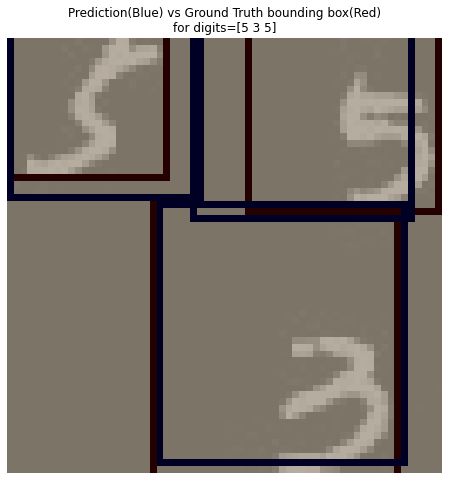

In [5]:
def inference(args):
    device = torch.device('cuda:'+str(args.device)) 
    model, criterion = build_model(args)
    model.to(device)
    infr_wts = torch.load(args.infr_model,map_location=device)
    model.load_state_dict(infr_wts)
    print('loaded model for inference')
    dataset_val = build_dataset(split='test', args=args)
    data_loader_val = DataLoader(dataset_val, batch_size=1,num_workers=args.num_workers,drop_last=False,shuffle=True,collate_fn=collate_fn)
    inference_fn(data_loader_val, model, device,args)

inference(get_args())